In [1]:
import numpy as np
import math
import random
import pandas as pd
import os
import matplotlib.pyplot as plt
import cv2
import glob
from tqdm import tqdm
import pickle
import scipy.ndimage.interpolation as inter
from scipy.signal import medfilt 
from scipy.spatial.distance import cdist

from keras.optimizers import *
from keras.models import Model
from keras.layers import *
from keras.layers.core import *
from tensorflow.keras.callbacks import *
from keras.layers.convolutional import *
from keras import backend as K
import keras
import tensorflow as tf


1. Define configurations

In [2]:
random.seed(1234)

class Config():
    def __init__(self):
        self.frame_l = 30 # the length of frames
        self.joint_n = 33 # the number of joints
        self.joint_d = 2 # the dimension of joints
        self.clc_num = 4 # the number of class
        self.feat_d = 528
        self.filters = 64
C = Config()

2. Define data processing functions

In [3]:
# Temple resizing function
def zoom(p,target_l=64,joints_num=33,joints_dim=2):
    l = p.shape[0]
    p_new = np.empty([target_l,joints_num,joints_dim]) 
    for m in range(joints_num):
        for n in range(joints_dim):
            p[:,m,n] = medfilt(p[:,m,n],3)
            p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]         
    return p_new



# Calculate JCD feature
def norm_scale(x):
    return (x-np.mean(x))/np.mean(x)
  
def get_CG(p,C):
    M = []
    iu = np.triu_indices(C.joint_n,1,C.joint_n)
    for f in range(C.frame_l): 
        d_m = cdist(p[f],p[f],'euclidean')       
        d_m = d_m[iu] 
        M.append(d_m)
    M = np.stack(M) 
    M = norm_scale(M)
    return M
  
  
# Genrate dataset  
def data_generator(T,C,le):
    X_0 = []
    X_1 = []
    Y = []
    for i in tqdm(range(len(T['pose']))): 
        p = np.copy(T['pose'][i])
        p = zoom(p,target_l=C.frame_l,joints_num=C.joint_n,joints_dim=C.joint_d)

        label = np.zeros(C.clc_num)
        label[le.transform(T['label'])[i]-1] = 1   

        M = get_CG(p,C)

        X_0.append(M)
        X_1.append(p)
        Y.append(label)

    X_0 = np.stack(X_0)  
    X_1 = np.stack(X_1) 
    Y = np.stack(Y)
    return X_0,X_1,Y

3. Define network

In [4]:
def poses_diff(x):
    H, W = x.get_shape()[1],x.get_shape()[2]
    x = tf.subtract(x[:,1:,...],x[:,:-1,...])
    x = tf.image.resize(x,size=[H,W]) 
    return x

def pose_motion(P,frame_l):
    P_diff_slow = Lambda(lambda x: poses_diff(x))(P)
    P_diff_slow = Reshape((frame_l,-1))(P_diff_slow)
    P_fast = Lambda(lambda x: x[:,::2,...])(P)
    P_diff_fast = Lambda(lambda x: poses_diff(x))(P_fast)
    P_diff_fast = Reshape((int(frame_l/2),-1))(P_diff_fast)
    return P_diff_slow,P_diff_fast
    
def c1D(x,filters,kernel):
    x = Conv1D(filters, kernel_size=kernel,padding='same',use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    return x

def block(x,filters):
    x = c1D(x,filters,3)
    x = c1D(x,filters,3)
    return x
    
def d1D(x,filters):
    x = Dense(filters,use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    return x

def build_FM(frame_l=30,joint_n=33,joint_d=2,feat_d=231,filters=16):   
    M = Input(shape=(frame_l,feat_d))
    P = Input(shape=(frame_l,joint_n,joint_d))
    
    diff_slow,diff_fast = pose_motion(P,frame_l)
    
    x = c1D(M,filters*2,1)
    x = SpatialDropout1D(0.1)(x)
    x = c1D(x,filters,3)
    x = SpatialDropout1D(0.1)(x)
    x = c1D(x,filters,1)
    x = MaxPooling1D(2)(x)
    x = SpatialDropout1D(0.1)(x)

    x_d_slow = c1D(diff_slow,filters*2,1)
    x_d_slow = SpatialDropout1D(0.1)(x_d_slow)
    x_d_slow = c1D(x_d_slow,filters,3)
    x_d_slow = SpatialDropout1D(0.1)(x_d_slow)
    x_d_slow = c1D(x_d_slow,filters,1)
    x_d_slow = MaxPool1D(2)(x_d_slow)
    x_d_slow = SpatialDropout1D(0.1)(x_d_slow)
        
    x_d_fast = c1D(diff_fast,filters*2,1)
    x_d_fast = SpatialDropout1D(0.1)(x_d_fast)
    x_d_fast = c1D(x_d_fast,filters,3) 
    x_d_fast = SpatialDropout1D(0.1)(x_d_fast)
    x_d_fast = c1D(x_d_fast,filters,1) 
    x_d_fast = SpatialDropout1D(0.1)(x_d_fast)
   
    x = concatenate([x,x_d_slow,x_d_fast])
    x = block(x,filters*2)
    x = MaxPool1D(2)(x)
    x = SpatialDropout1D(0.1)(x)
    
    x = block(x,filters*4)
    x = MaxPool1D(2)(x)
    x = SpatialDropout1D(0.1)(x)

    x = block(x,filters*8)
    x = SpatialDropout1D(0.1)(x)
    
    return Model(inputs=[M,P],outputs=x)


def build_DD_Net(C):
    M = Input(name='M', shape=(C.frame_l,C.feat_d))  
    P = Input(name='P', shape=(C.frame_l,C.joint_n,C.joint_d)) 
    
    FM = build_FM(C.frame_l,C.joint_n,C.joint_d,C.feat_d,C.filters)
    
    x = FM([M,P])

    x = GlobalMaxPool1D()(x)
    
    x = d1D(x,128)
    x = Dropout(0.5)(x)
    x = d1D(x,128)
    x = Dropout(0.5)(x)
    x = Dense(C.clc_num, activation='softmax')(x)
    
    ######################Self-supervised part
    model = Model(inputs=[M,P],outputs=x)
    return model

In [5]:
DD_Net = build_DD_Net(C)
# DD_Net.summary()

2023-02-21 10:46:07.810422: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-02-21 10:46:07.810456: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (Harley): /proc/driver/nvidia/version does not exist
2023-02-21 10:46:07.810724: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
Train = pickle.load(open("dataset/train.pkl", "rb"))
Test = pickle.load(open("dataset/test.pkl", "rb"))

from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(Train['label'])

X_0,X_1,Y = data_generator(Train,C,le)
X_test_0,X_test_1,Y_test = data_generator(Test,C,le)

  0%|          | 0/160 [00:00<?, ?it/s]/tmp/ipykernel_41581/992751888.py:8: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
100%|██████████| 20/20 [00:00<00:00, 74.24it/s]


5. Start train on split 1

In [7]:
lr = 1e-3
DD_Net.compile(loss="categorical_crossentropy",optimizer=keras.optimizers.Adam(lr),metrics=['accuracy'])
lrScheduler = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, cooldown=5, min_lr=5e-6)
history = DD_Net.fit([X_0,X_1],Y,
                    batch_size=len(Y),
                    epochs=10,
                    verbose=True,
                    shuffle=True,
                    callbacks=[lrScheduler],
                    validation_data=([X_test_0,X_test_1],Y_test)      
                    )

Epoch 1/10
1/1 [==============================] - 8s 8s/step - loss: 2.1360 - accuracy: 0.1562 - val_loss: 1.3800 - val_accuracy: 0.2500 - lr: 0.0010
Epoch 2/10
1/1 [==============================] - 1s 597ms/step - loss: 1.2301 - accuracy: 0.4625 - val_loss: 1.3750 - val_accuracy: 0.2500 - lr: 0.0010
Epoch 3/10
1/1 [==============================] - 1s 604ms/step - loss: 1.0235 - accuracy: 0.5688 - val_loss: 1.3713 - val_accuracy: 0.2500 - lr: 0.0010
Epoch 4/10
1/1 [==============================] - 1s 599ms/step - loss: 0.8803 - accuracy: 0.6375 - val_loss: 1.3649 - val_accuracy: 0.2500 - lr: 0.0010
Epoch 5/10
1/1 [==============================] - 1s 596ms/step - loss: 0.7326 - accuracy: 0.6875 - val_loss: 1.3485 - val_accuracy: 0.2500 - lr: 0.0010
Epoch 6/10
1/1 [==============================] - 1s 579ms/step - loss: 0.6210 - accuracy: 0.7125 - val_loss: 1.3228 - val_accuracy: 0.2500 - lr: 0.0010
Epoch 7/10
1/1 [==============================] - 1s 613ms/step - loss: 0.6642 - accu

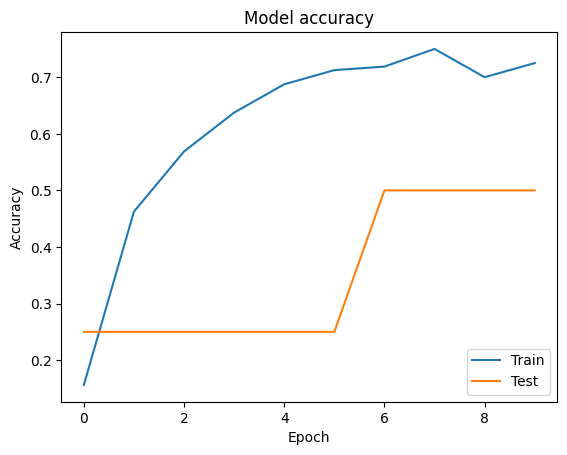

In [8]:

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='lower right')
plt.show()

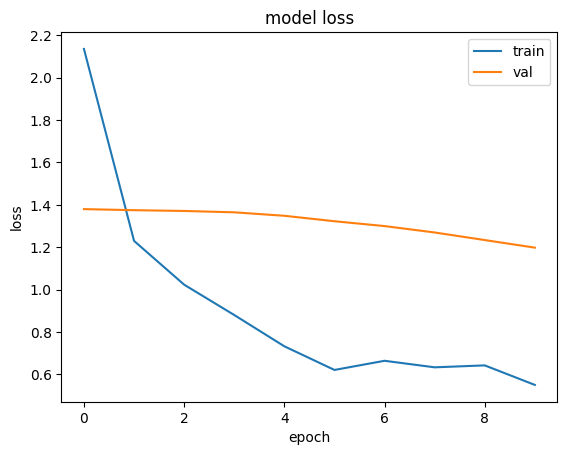

In [9]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [10]:
DD_Net.save("ddnet2.h5")

In [11]:
# C = Config()
# DD_Net = build_DD_Net(C)
# DD_Net.load_weights("ddnet1.h5")

In [15]:
def data_generator_rt(T,C):
    X_0 = []
    X_1 = []

    T = np.expand_dims(T, axis = 0)
    for i in tqdm(range(len(T))): 
        p = np.copy(T[i])
        p = zoom(p,target_l=C.frame_l,joints_num=C.joint_n,joints_dim=C.joint_d)

        M = get_CG(p,C)

        X_0.append(M)
        X_1.append(p)

    X_0 = np.stack(X_0)  
    X_1 = np.stack(X_1) 

    return X_0,X_1


In [16]:
pred = []
threshold = 0.5
for action_ID in range(1,4):
    for event_ID in range(1,6):
        file = open('dataset/keypoint/a0{}_s05_e0{}_skeleton3D.txt'.format(action_ID, event_ID),'r')
        data = np.loadtxt(file, dtype=float)
        data = np.reshape(data, (int(data.shape[0]/33),33,3))
        data = data_generator_rt(data, C)
        out  = DD_Net.predict(data)
        
        # out = (out > threshold).astype(float)
        pred.append(out)
print(pred)

  0%|          | 0/1 [00:00<?, ?it/s]/tmp/ipykernel_41581/992751888.py:8: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
100%|██████████| 1/1 [00:00<00:00, 61.35it/s]


1/1 [==============================] - 1s 753ms/step


100%|██████████| 1/1 [00:00<00:00, 61.30it/s]

1/1 [==============================] - 0s 34ms/step



100%|██████████| 1/1 [00:00<00:00, 63.20it/s]


1/1 [==============================] - 0s 29ms/step


100%|██████████| 1/1 [00:00<00:00, 51.17it/s]


1/1 [==============================] - 0s 43ms/step


100%|██████████| 1/1 [00:00<00:00, 56.56it/s]


1/1 [==============================] - 0s 48ms/step


100%|██████████| 1/1 [00:00<00:00, 37.63it/s]


1/1 [==============================] - 0s 50ms/step


100%|██████████| 1/1 [00:00<00:00, 44.54it/s]


1/1 [==============================] - 0s 31ms/step


100%|██████████| 1/1 [00:00<00:00, 62.72it/s]


1/1 [==============================] - 0s 30ms/step


100%|██████████| 1/1 [00:00<00:00, 40.15it/s]


1/1 [==============================] - 0s 46ms/step


100%|██████████| 1/1 [00:00<00:00, 67.35it/s]


1/1 [==============================] - 0s 35ms/step


100%|██████████| 1/1 [00:00<00:00, 35.75it/s]


1/1 [==============================] - 0s 44ms/step


100%|██████████| 1/1 [00:00<00:00, 52.88it/s]


1/1 [==============================] - 0s 31ms/step


100%|██████████| 1/1 [00:00<00:00, 34.26it/s]


1/1 [==============================] - 0s 40ms/step


100%|██████████| 1/1 [00:00<00:00, 25.83it/s]


1/1 [==============================] - 0s 42ms/step


100%|██████████| 1/1 [00:00<00:00, 45.44it/s]


1/1 [==============================] - 0s 34ms/step
[array([[0.33737803, 0.1700873 , 0.20444855, 0.2880861 ]], dtype=float32), array([[0.32976192, 0.1664789 , 0.20318681, 0.3005723 ]], dtype=float32), array([[0.32153738, 0.17001472, 0.20673148, 0.30171648]], dtype=float32), array([[0.331777  , 0.1696582 , 0.20522414, 0.29334062]], dtype=float32), array([[0.32642272, 0.17082646, 0.20584017, 0.29691064]], dtype=float32), array([[0.37515026, 0.19189057, 0.21073541, 0.22222373]], dtype=float32), array([[0.36534318, 0.19404392, 0.21342424, 0.2271887 ]], dtype=float32), array([[0.36152005, 0.19834669, 0.21665747, 0.22347577]], dtype=float32), array([[0.35499385, 0.20192257, 0.21992165, 0.22316198]], dtype=float32), array([[0.3674154 , 0.1928732 , 0.21253212, 0.22717918]], dtype=float32), array([[0.23614915, 0.2700387 , 0.27959844, 0.21421376]], dtype=float32), array([[0.23580067, 0.2722471 , 0.27770552, 0.2142467 ]], dtype=float32), array([[0.21632549, 0.28929135, 0.28968582, 0.20469737]], d

In [14]:
# data1 = np.loadtxt("dataset/keypoint/a02_s01_e01_skeleton3D.txt", dtype=float)
# data1 = np.array(data1)
# print(data1.shape)
# data1 = np.reshape(data1, (81,33,3))
# data1 = data_generator_rt(data1, C)
# out  = DD_Net.predict(data1)
# print(out)